In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm_notebook as tqdm
import _pickle as pk

torch.manual_seed(1)
random.seed(1)

import copy, warnings
warnings.simplefilter("ignore", UserWarning)
import datetime

In [2]:
config = {
    'num_train': 20000,
    'num_valid': 5000,
    'patience': 10,
    'batch': 32,
    'epoch': 3000,
    'lr': 0.001,
    'momentum': 0.99,
    'emb_size': 64,
    'lstm_size': 128,
    'pred_size': 10,
    'testfile': "../data/raw/test.txt",
    'logfile': "model_loop_noattn.log",
    'lossfile': 'model_loop_noattn.loss',
    'checkpoint': "model_loop_noattn.pt"
}

open(config['logfile'], 'w').close()
def saveLogMsg(msg):
    print(msg, "\n")
    with open(config['logfile'], "a") as myfile:
        myfile.write(msg + "\n")
        
saveLogMsg("Initializing imports and config...")

Initializing imports and config... 



In [3]:
def sorting_letters_dataset(size):
    dataset = []
    for _ in range(size):
        x = []
        for _ in range(random.randint(3, 10)):
            letter = chr(random.randint(97, 122))
            repeat = [letter] * random.randint(1, 3)
            x.extend(repeat)
        y = sorted(set(x))
        dataset.append((x, y))
    return zip(*dataset)

train_inp, train_out = sorting_letters_dataset(config['num_train'])
valid_inp, valid_out = sorting_letters_dataset(config['num_valid'])

saveLogMsg("Dataset for train and valid...")

Dataset for train and valid... 



In [4]:
class Vocab:
    def __init__(self, vocab):
        self.itos = vocab
        self.stoi = {d:i for i, d in enumerate(self.itos)}
        
    def __len__(self):
        return len(self.itos) 

src_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)])
tgt_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)] + ['<start>', '<stop>'] )

START_IX = tgt_vocab.stoi['<start>']
STOP_IX  = tgt_vocab.stoi['<stop>']

saveLogMsg("Vocab for source and target...")

Vocab for source and target... 



In [5]:
def map_elems(elems, mapper):
    return [mapper[elem] for elem in elems]

def map_many_elems(many_elems, mapper):
    return [map_elems(elems, mapper) for elems in many_elems]

train_x = map_many_elems(train_inp, src_vocab.stoi)
train_y = map_many_elems(train_out, tgt_vocab.stoi)

valid_x = map_many_elems(valid_inp, src_vocab.stoi)
valid_y = map_many_elems(valid_out, tgt_vocab.stoi)

saveLogMsg("Mapping dataset through Vocab...")

Mapping dataset through Vocab... 



In [6]:
test_data = pd.read_csv(config['testfile'], delimiter='\t', header=None, usecols=[0,1])
test_inp, test_out = test_data[0], test_data[1]  

test_x = map_many_elems(test_inp, src_vocab.stoi)
test_y = map_many_elems(test_out, tgt_vocab.stoi)

saveLogMsg("Loading test dataset from {}.".format(config['testfile']))

Loading test dataset from ../data/raw/test.txt. 



In [7]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, z_type, dropout=0.5):
        super(Encoder, self).__init__()
        self.z_index = z_type
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, lstm_size, batch_first=True)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, inputs):
        device = next(self.parameters()).device
        
        x_tensor = [torch.tensor(sample).to(device) for sample in inputs]
        x_pad = pad_sequence(x_tensor, batch_first=True, padding_value=0) # (batch, seqlen) 
        x_emb = self.emb(x_pad) # (batch, seqlen, emb_dim) 
        x_emb = self.drop(x_emb)
        
        x_len = [len(sample) for sample in inputs]
        x_pack = pack_padded_sequence(x_emb, x_len, batch_first=True, enforce_sorted=False)
        outs_pack, (h_n, c_n) = self.lstm(x_pack)
        outs, _ = pad_packed_sequence(outs_pack, batch_first=True)
        
        if self.z_index == 1:
            return h_n, c_n # (seqlen, batch, lstm_dim)
        else:
            return outs # (batch, seqlen, lstm_dim)

encoder = Encoder(vocab_size=len(src_vocab), 
                  emb_dim=config['emb_size'], 
                  lstm_size=config['lstm_size'], 
                  z_type=1)
saveLogMsg("encoder:\n{}".format(encoder))

encoder:
Encoder(
  (emb): Embedding(27, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
) 



In [8]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, dropout=0.5):
        super(Decoder, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTMCell(emb_dim, lstm_size)
        self.clf = nn.Linear(lstm_size, vocab_size)
        
        self.drop = nn.Dropout(dropout)
        self.objective = nn.CrossEntropyLoss(reduction="none")
        
    def forward(self, batch_state, batch_targets, curr_token_raw, last_token_raw):
        device = next(self.parameters()).device
        
        batch_state_h, batch_state_c = batch_state # (seqlen, batch, lstm_dim)
        batch_state_ht = batch_state_h.transpose(0, 1) # (batch, seqlen, lstm_dim)
        batch_state_ct = batch_state_c.transpose(0, 1) # (batch, seqlen, lstm_dim)
        
        batch_loss = 0.0
        for targets, state_h, state_c in zip(batch_targets, batch_state_ht, batch_state_ct):
            curr_token, last_token = curr_token_raw, last_token_raw
            state = (state_h, state_c)
            shifted = targets + [last_token]
            
            each_loss = 0.0
            for i in range(len(shifted)):
                inp = torch.tensor([curr_token]).to(device)

                emb = self.emb(inp)
                emb = self.drop(emb)

                state = self.lstm(emb, state)
                q_i, _ = state 
                q_i = self.drop(q_i)
        
                scores = self.clf(q_i)
                target = torch.tensor([shifted[i]]).to(device)
                each_loss += self.objective(scores, target)

                curr_token = shifted[i]
            
            batch_loss += (each_loss / len(shifted) * 1.0)
            
        return batch_loss

    def predict(self, batch_state, curr_token_raw, last_token_raw, maxlen):
        device = next(self.parameters()).device
        
        batch_state_h, batch_state_c = batch_state # (seqlen, batch, lstm_dim)
        batch_state_ht = batch_state_h.transpose(0, 1) # (batch, seqlen, lstm_dim)
        batch_state_ct = batch_state_c.transpose(0, 1) # (batch, seqlen, lstm_dim)
        
        batch_preds = []
        for state_h, state_c in zip(batch_state_ht, batch_state_ct):
            curr_token, last_token = curr_token_raw, last_token_raw
            state = (state_h, state_c)
            
            each_preds = []
            for i in range(maxlen):
                inp = torch.tensor([curr_token]).to(device)
                
                emb = self.emb(inp)

                state = self.lstm(emb, state)
                h_i, _ = state

                scores = self.clf(h_i)
                pred = torch.argmax(torch.softmax(scores, dim=1))
                curr_token = pred

                if last_token == pred:
                    break
                each_preds.append(pred)
                
            batch_preds.append(each_preds)
            
        return batch_preds
    
    def evaluate(self, batch_state, batch_targets, curr_token_raw, last_token_raw):
        device = next(self.parameters()).device
        
        batch_state_h, batch_state_c = batch_state # (seqlen, batch, lstm_dim)
        batch_state_ht = batch_state_h.transpose(0, 1) # (batch, seqlen, lstm_dim)
        batch_state_ct = batch_state_c.transpose(0, 1) # (batch, seqlen, lstm_dim)
        
        batch_preds = []
        batch_loss = 0.0
        for state_h, state_c, targets in zip(batch_state_ht, batch_state_ct, batch_targets):
            curr_token, last_token = curr_token_raw, last_token_raw
            state = (state_h, state_c)
            shifted = targets + [last_token]
            
            each_preds = []
            each_loss = 0.0
            for i in range(len(shifted)):
                inp = torch.tensor([curr_token]).to(device)
                
                emb = self.emb(inp)

                state = self.lstm(emb, state)
                h_i, _ = state

                scores = self.clf(h_i)
                target = torch.tensor([shifted[i]]).to(device)
                each_loss += self.objective(scores, target)
                
                pred = torch.argmax(torch.softmax(scores, dim=1))
                curr_token = pred

                if last_token == pred:
                    break
                each_preds.append(pred)
                
            batch_loss += (each_loss / len(each_preds) * 1.0)
            batch_preds.append(each_preds)
            
        return batch_preds, batch_loss

decoder = Decoder(vocab_size=len(tgt_vocab), 
                  emb_dim=config['emb_size'], 
                  lstm_size=config['lstm_size'])
saveLogMsg("decoder:\n{}".format(decoder))

decoder:
Decoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (clf): Linear(in_features=128, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
) 



In [9]:
def map_prediction(sample_preds):
    sample_preds = [[tgt_vocab.itos[ix] for ix in each_preds] for each_preds in sample_preds]
    sample_preds = [''.join(each_preds) for each_preds in sample_preds]
    return sample_preds

def predict(encoder, decoder, sample_x, batch_size, pred_size):
    encoder.eval()
    decoder.eval()
    
    batch_x = []
    predictions = []
    
    with torch.no_grad():
        for i in range(len(sample_x)):
            batch_x.append(sample_x[i])
            
            if len(batch_x) == batch_size or i == len(sample_x) - 1:
                batch_preds = decoder.predict(encoder(batch_x), START_IX, STOP_IX, pred_size)
                batch_preds = map_prediction(batch_preds)
                predictions.extend(batch_preds)
                batch_x = []
            
    return predictions

def evaluate(encoder, decoder, sample_x, sample_y, batch_size):
    encoder.eval()
    decoder.eval()
    
    sample_loss = 0.0
    batch_x, batch_y = [], []
    predictions, actuals = [], []
    
    with torch.no_grad():
        for i in range(len(sample_x)):
            batch_x.append(sample_x[i])
            batch_y.append(sample_y[i])
            
            if len(batch_x) == batch_size or i == len(sample_x) - 1:
                batch_preds, batch_loss = decoder.evaluate(encoder(batch_x), batch_y, START_IX, STOP_IX)
                
                batch_preds = map_prediction(batch_preds)
                predictions.extend(batch_preds)
                batch_y = map_prediction(batch_y)
                actuals.extend(batch_y)
                
                sample_loss += batch_loss.item()
                batch_x, batch_y = [], []
    
    sample_loss = sample_loss / len(sample_x) * 1.0
    
    accuracy = accuracy_score(actuals, predictions)
    return predictions, sample_loss, accuracy

def train(encoder, enc_optim, decoder, dec_optim, train_x, train_y, batch_size):
    encoder.train()
    decoder.train()

    train_loss = 0.0
    train_x, train_y = shuffle(train_x, train_y)
    batch_x, batch_y = [], []

    for i in range(len(train_x)):
        batch_x.append(train_x[i])
        batch_y.append(train_y[i])

        if len(batch_x) == batch_size or i == len(train_x) - 1:
            batch_loss = decoder(encoder(batch_x), batch_y, START_IX, STOP_IX)

            batch_loss.backward()
            enc_optim.step()
            dec_optim.step()

            encoder.zero_grad(); enc_optim.zero_grad()
            decoder.zero_grad(); dec_optim.zero_grad()

            train_loss += batch_loss.item()
            batch_x, batch_y = [], []

    train_loss = train_loss / len(train_x) * 1.0
    
    return encoder, decoder, train_x, train_y, train_loss


In [10]:
def shuffle(x, y):
    pack = list(zip(x, y))
    random.shuffle(pack)
    return zip(*pack)

def track_best_model(encoder, decoder, epoch, best_acc, valid_acc, valid_loss, patience_track):
    if best_acc >= valid_acc:
        return best_acc, '', patience_track+1
    state = {
        'encoder': encoder.state_dict(), 
        'decoder': decoder.state_dict(),
        'acc': valid_acc,
        'loss': valid_loss,
        'epoch': epoch
    }
    torch.save(state, config['checkpoint'])
    return valid_acc, ' * ', 0

def load_best_model():
    encoder = Encoder(vocab_size=len(src_vocab), 
                  emb_dim=config['emb_size'], 
                  lstm_size=config['lstm_size'], 
                  z_type=1)
    decoder = Decoder(vocab_size=len(tgt_vocab), 
                  emb_dim=config['emb_size'], 
                  lstm_size=config['lstm_size'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state = torch.load(config['checkpoint'], map_location=device)
    encoder.load_state_dict(state['encoder'])
    decoder.load_state_dict(state['decoder'])
    state = {'acc': state['acc'], 'loss': state['loss'], 'epoch': state['epoch']}
    return encoder, decoder, state

def getCurrentTime():
    return str(datetime.datetime.now())

def getAccuracyScore(encoder, decoder, sample_x, sample_out):
    predictions = predict(encoder, decoder, sample_x, config['batch'], config['pred_size'])
    groundtruth = [''.join(str_y) for str_y in sample_out]
    acc = accuracy_score(groundtruth, predictions)
    return acc

def training_loop(encoder, decoder, train_x, train_y, epochs, batch_size, print_every=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    encoder.to(device)
    decoder.to(device)

    enc_optim = optim.SGD(encoder.parameters(), lr=config['lr'], momentum=config['momentum'])
    dec_optim = optim.SGD(decoder.parameters(), lr=config['lr'], momentum=config['momentum'])
    
    best_acc = -1.0
    patience_track = 0
    keep_loss = [[], []] # [[train],[valid]]
    
    for epoch in range(1, epochs+1):
        encoder.zero_grad(); enc_optim.zero_grad()
        decoder.zero_grad(); dec_optim.zero_grad()
        
        encoder, decoder, train_x, train_y, train_loss = train(encoder, enc_optim, decoder, dec_optim, train_x, train_y, batch_size)
        _, valid_loss, valid_acc = evaluate(encoder, decoder, valid_x, valid_y, batch_size)
        best_acc, epoch_track, patience_track = track_best_model(encoder, decoder, epoch, best_acc, valid_acc, valid_loss, patience_track)
        test_acc = getAccuracyScore(encoder, decoder, test_x, test_out)
        
        keep_loss[0].append(train_loss)
        keep_loss[1].append(valid_loss)
        
        if epoch % print_every == 0:
            epoch_msg = '[{}] Epoch {}:\n [TRAIN] Loss: {:.6f}'.format(getCurrentTime(), epoch, train_loss)
            epoch_msg += ' [DEV] Loss: {:.6f}, Acc: {:.6f}'.format(valid_loss, valid_acc)
            epoch_msg += ' [TEST] Acc: {:.6f}'.format(test_acc)
            saveLogMsg(epoch_msg + epoch_track)
            
        if patience_track == int(config['patience']):
            saveLogMsg('No accuracy improvment for {} consecutive epochs, stopping training...'.format(config['patience']))
            break
    
    best_encoder, best_decoder, _ = load_best_model()
    with open(config['lossfile'], 'wb') as lossfile:
        pk.dump(keep_loss, lossfile)
    
    return best_encoder, best_decoder, keep_loss

In [11]:
if True: #not os.path.exists(config['checkpoint']):
    saveLogMsg("Training with encoder and decoder...")
    training_loop(encoder, decoder, train_x, train_y, config['epoch'], config['batch'], print_every=1)
    saveLogMsg('Training done...')

Training with encoder and decoder... 

[2020-04-09 14:50:55.379515] Epoch 1:
 [TRAIN] Loss: 1.844442 [DEV] Loss: 1.485004, Acc: 0.275800 [TEST] Acc: 0.179200 *  

[2020-04-09 14:53:02.161138] Epoch 2:
 [TRAIN] Loss: 0.725624 [DEV] Loss: 0.566061, Acc: 0.741200 [TEST] Acc: 0.595800 *  

[2020-04-09 14:54:51.879143] Epoch 3:
 [TRAIN] Loss: 0.378644 [DEV] Loss: 0.213370, Acc: 0.904600 [TEST] Acc: 0.758400 *  

[2020-04-09 14:57:13.084958] Epoch 4:
 [TRAIN] Loss: 0.213595 [DEV] Loss: 0.071513, Acc: 0.965200 [TEST] Acc: 0.853200 *  

[2020-04-09 14:59:50.049918] Epoch 5:
 [TRAIN] Loss: 0.142425 [DEV] Loss: 0.038960, Acc: 0.982200 [TEST] Acc: 0.867000 *  

[2020-04-09 15:02:27.214465] Epoch 6:
 [TRAIN] Loss: 0.099749 [DEV] Loss: 0.037703, Acc: 0.984200 [TEST] Acc: 0.874600 *  

[2020-04-09 15:04:51.297170] Epoch 7:
 [TRAIN] Loss: 0.079309 [DEV] Loss: 0.019547, Acc: 0.990800 [TEST] Acc: 0.896800 *  

[2020-04-09 15:07:44.974085] Epoch 8:
 [TRAIN] Loss: 0.068503 [DEV] Loss: 0.036061, Acc: 0.98

In [12]:
keep_loss = [[], []] # [[train],[valid]]
with open(config['lossfile'], 'rb') as lossfile:
    keep_loss = pk.load(lossfile)
encoder, decoder, state = load_best_model()
saveLogMsg('Returning best model from epoch {} with loss {:.6f} and accuracy {:.6f}.'.format(state['epoch'], state['loss'], state['acc'])) 

Returning best model from epoch 22 with loss 0.007088 and accuracy 0.997800. 



Retrieving training and validation loss... 



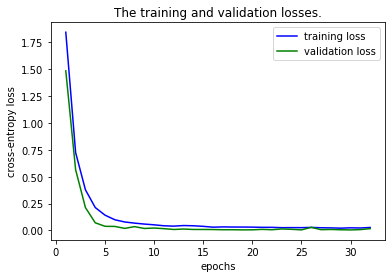

In [13]:
saveLogMsg('Retrieving training and validation loss...')

keep_loss = [[], []] # [[train],[valid]]
with open(config['lossfile'], 'rb') as lossfile:
    keep_loss = pk.load(lossfile)

# Refs: https://matplotlib.org/tutorials/introductory/pyplot.html
import matplotlib.pyplot as plt
%matplotlib inline

epochs = [i for i in range(1, len(keep_loss[0])+1)]
plt.plot(epochs, keep_loss[0], 'b', label="training loss")
plt.plot(epochs, keep_loss[1], 'g', label="validation loss")
plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.ylabel('cross-entropy loss')
plt.title('The training and validation losses.')
plt.show()